In [37]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import recarray

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms
import torch.utils.data as data
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os
import copy
import platform
import secrets

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

on cuda


In [38]:
class mHealth(data.Dataset):

    def __init__(self, dataframe, labels):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe
        self.labels = labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        #find the most common label in the labels array and make the sequence equal to that label
        # print(self.labels)
        count = Counter(self.labels.iloc[index:index+128])
        # print("count: ", count)
        # print(self.labels.iloc[index:index+128].value_counts())
        labels = count.most_common()[0]
        # labels = Counter(self.labels.iloc[index:index+128]).most_common(1)[0][0]
        # print("count: ", labels)
        
        return sequence, labels
    
def collate_fn(batch):

    labels = []
    for idx, d in batch:
        labels.append(torch.tensor(d[0]))
    
    labels = torch.tensor(labels)
    inputs = [torch.tensor(d[0]) for d in batch]
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, labels

In [39]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        x = x.to(device)
        
        out, (hn, _) = self.lstm(x, (h0, c0))
        hn = hn[-1].to(device)
        # print('hn shape: ', hn.shape)
        
        mu = self.fc_mu(hn)
        logvar = self.fc_logvar(hn)
        
        return mu, logvar, out, hn  # return out for skip connection

class AutoregressiveLSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=1):
        super(AutoregressiveLSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # self.skip_dim = skip_dim
        self.lstm = nn.LSTM(latent_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z, x_skip):
        batch_size, seq_len, _ = x_skip.size()
        z = z.unsqueeze(1).repeat(1, seq_len, 1)
        
        x_input = torch.cat((z, x_skip), dim=2)  # Concatenate z and skip connection
        
        h0 = torch.zeros(self.num_layers, x_input.size(0), self.hidden_dim).to(x_input.device)
        c0 = torch.zeros(self.num_layers, x_input.size(0), self.hidden_dim).to(x_input.device)
        
        out, _ = self.lstm(x_input, (h0, c0))
        out = self.fc(out)
        
        return out

class LSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, num_layers=1, beta=1.0):
        super(LSTMVAE, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim, num_layers)
        self.decoder = AutoregressiveLSTMDecoder(latent_dim, hidden_dim, output_dim, num_layers)
        self.beta = beta
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        mu, logvar, _, hn = self.encoder(x)
        
        return mu, logvar, hn, _
    
    def forward(self, x):
        mu, logvar, x_skip, _ = self.encoder(x)
        z = self.reparameterize(mu, logvar)

        recon_x = self.decoder(z, x_skip)
        
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

0        -3.948768
1        -3.963551
2        -3.872089
3        -3.867484
4        -3.892834
            ...   
161275   -3.747522
161276   -3.804183
161277   -3.730558
161278   -3.392240
161279   -3.416911
Length: 161280, dtype: float64

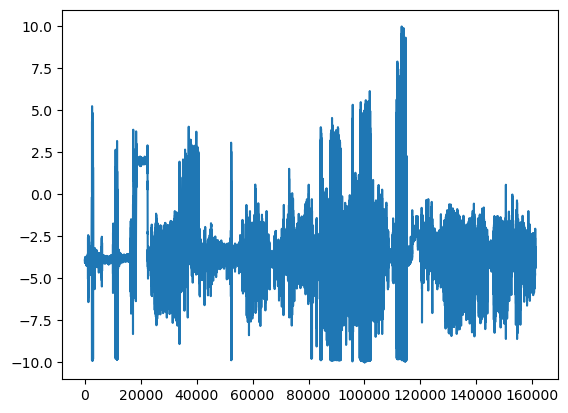

In [40]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)

labels = dataset['label']
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info

dataset = dataset.to_numpy().reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-10, 10))

dataset = scaler.fit_transform(dataset)
dataset = pd.Series(dataset.squeeze())
plt.plot(dataset)
dataset

In [41]:
split_idx = int(len(dataset) * 0.8)

print(labels[:split_idx].value_counts())

train_set = mHealth(
    dataframe=dataset[:split_idx],
    labels = labels[:split_idx]
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
    labels = labels[split_idx:]
)

# training dataset
# train_set = mHealth(
#     dataframe=dataset[:split_idx],
# )

# test_set = mHealth(
#     dataframe=dataset[split_idx:],
# )

batch_size = 128
# input_size = 1
# hidden_size = 256
# latent_size = 128
# sequence_len = 128
# num_layers = 2
clip_value = 10

# Example usage:
input_dim = 1
hidden_dim = 256
latent_dim = 128
output_dim = 1
seq_len = 128
num_layers = 2
beta = 0.1  # Beta for KL term, could be annealed

model = LSTMVAE(input_dim, hidden_dim, latent_dim, output_dim, num_layers, beta)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

model.to(device)
print("training on: ", device)
print('----------------------------------------------------------------\n', model)

label
0.0     96922
8.0      3379
1.0      3072
2.0      3072
3.0      3072
4.0      3072
6.0      3072
7.0      3072
9.0      3072
10.0     3072
11.0     3072
12.0     1075
Name: count, dtype: int64
training on:  cuda
----------------------------------------------------------------
 LSTMVAE(
  (encoder): LSTMEncoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
    (fc_mu): Linear(in_features=256, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): AutoregressiveLSTMDecoder(
    (lstm): LSTM(384, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [42]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for data, label in train_loader:
    datas = data
    labels = label
    print("datas shape: ", datas.shape)
    break

train_loss = []
test_loss = []
learning_rate = []

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x0000018DA053B0D0>
Length of train_dataloader: 1008 batches of 128
datas shape:  torch.Size([128, 128, 1])


C:\Users\Admin\AppData\Local\Temp\ipykernel_65388\2789512198.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in batch]


In [43]:
def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    ## interation setup
    epochs = iterations

    ## training
    count = 0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        temp = -1
        
        for batch_data, label in train_loader:

            if count > iterations:
                return model
            
            if (count % 10000 != 0):
                beta += 0.001
            else:
                beta = 0.1
                
            count += 1

            past_data = batch_data
            # print(past_data.shape)
            # Backward and optimize
            optimizer.zero_grad()

            recon_x, mu, logvar = model(past_data)
            
            # print("recon x shapeL ", recon_x.shape)

            loss = loss_function(recon_x.to(device), past_data.to(device), mu, logvar, beta)

            loss.backward()
            optimizer.step()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            print({"train_loss": float(loss.mean())})
            temp = float(loss.mean())
            
        if(temp != -1):
            train_loss.append(temp)
            
        before_lr = optimizer.param_groups[0]["lr"]
        learning_rate.append(float(before_lr))
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        model.eval()
        eval_loss = 0

        with torch.no_grad():
            for batch_data, label in test_loader:
                past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                recon_x, mu, logvar = model(past_data)

                loss = model.loss_function(recon_x, past_data, mu, logvar, beta)

                eval_loss += loss

                print({"test_loss", float(loss)})
                temp = float(loss.mean)
            
        if(temp != -1):
            test_loss.append(temp)
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
        torch.cuda.empty_cache()

    return model


In [44]:
iterations = 100 # iterations = total iterations, epochs = iterations / len(dataloader)
train(iterations, model, train_loader, test_loader)

{'train_loss': 17.037385940551758}


C:\Users\Admin\AppData\Local\Temp\ipykernel_65388\2789512198.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in batch]


{'train_loss': 16.86944580078125}
{'train_loss': 16.590845108032227}
{'train_loss': 16.277366638183594}
{'train_loss': 15.714057922363281}
{'train_loss': 15.064314842224121}
{'train_loss': 14.282278060913086}
{'train_loss': 13.593913078308105}
{'train_loss': 13.38715934753418}
{'train_loss': 12.926356315612793}
{'train_loss': 12.106322288513184}
{'train_loss': 11.689976692199707}
{'train_loss': 11.026991844177246}
{'train_loss': 10.445548057556152}
{'train_loss': 10.191377639770508}
{'train_loss': 9.639476776123047}
{'train_loss': 9.153326034545898}
{'train_loss': 8.647147178649902}
{'train_loss': 9.941574096679688}
{'train_loss': 24.913387298583984}
{'train_loss': 26.357454299926758}
{'train_loss': 25.89312744140625}
{'train_loss': 15.747180938720703}
{'train_loss': 5.791411876678467}
{'train_loss': 5.361372947692871}
{'train_loss': 5.13019323348999}
{'train_loss': 4.913071155548096}
{'train_loss': 4.4613213539123535}


KeyboardInterrupt: 

In [ ]:
print(label.value_count())

AttributeError: 'Tensor' object has no attribute 'value_count'

C:\Users\Admin\AppData\Local\Temp\ipykernel_65388\2789512198.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in batch]


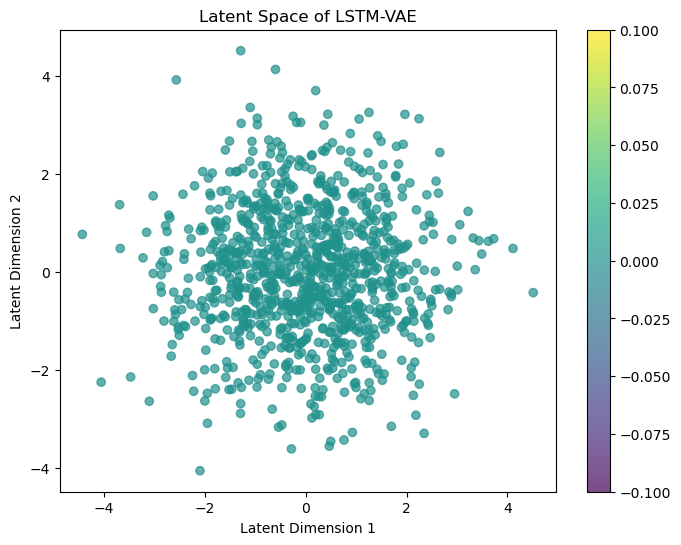

In [ ]:
model.eval()
latent_vectors = []
labels = []
n_samples = 1000
    
with torch.no_grad():
    for data, label in (test_loader):
        data = data.to(next(model.parameters()).device)
        z_mean, z_log_var, _, _ = model.encode(data)
        z = model.reparameterize(z_mean, z_log_var)
        latent_vectors.append(z.cpu().numpy())
        labels.append(label.cpu().numpy())

        if len(latent_vectors) * data.shape[0] >= n_samples:
            break
        
latent_vectors = np.concatenate(latent_vectors)[:n_samples]
labels = np.concatenate(labels)[:n_samples] 

reducer = PCA(n_components=2)
latent_vectors = reducer.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='viridis', alpha=0.7)
# scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels)
plt.colorbar(scatter)
plt.title("Latent Space of LSTM-VAE")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

In [ ]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:

            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary

            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )

            mloss, recon_x, info = model(x)

            recon_x = recon_x[:, 0]
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [ ]:
def plot_predictions(model):
    for i in range(2):

        path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject' + str(i+1) + '.csv'
        df = pd.read_csv(path)
        
        df = df['chest acceleration X-axis']
        
        df = df.to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(-10, 10))

        df = scaler.fit_transform(df)
        df = pd.Series(df.squeeze())
        
        dataset = mHealth(
            dataframe=df,
        )
        
        dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=512,
            collate_fn=collate_fn,
            shuffle=False,
            drop_last=True
        )
        
        reconstructed_data = predict(model, dataloader)
        
        plt.figure(figsize=(16,5))
        # plt.plot(df, label="True Data")
        plt.plot(reconstructed_data.cpu(), label="Reconstructed Data")
        plt.title("Recon Vs. True, Train Data")
        plt.legend()
                

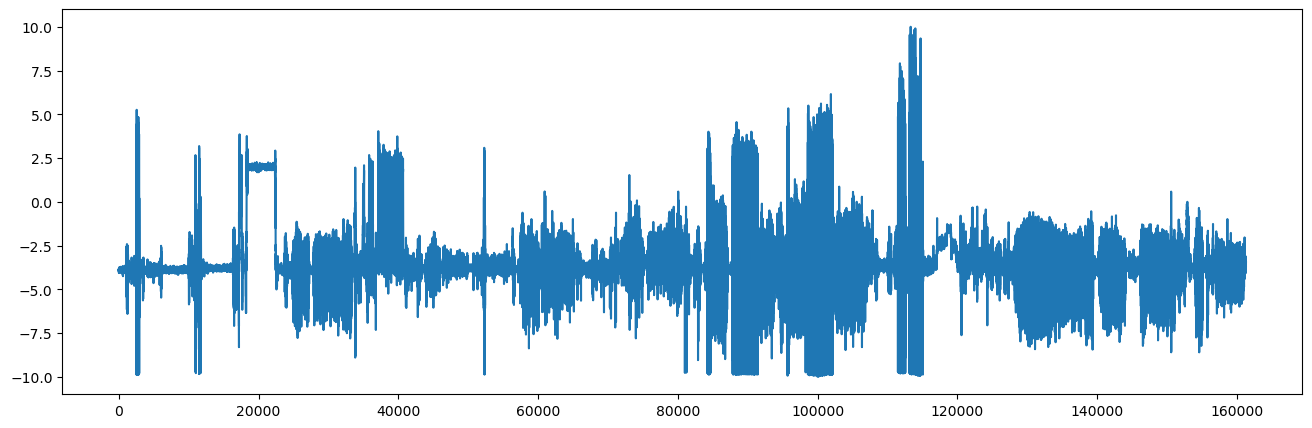

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(dataset)

In [ ]:
plot_predictions(model)

TypeError: mHealth.__init__() missing 1 required positional argument: 'labels'

In [ ]:
def plot_predictions_daphnet(model):
    
    folder_path = 'C:\\Users\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV'
    os.chdir(folder_path)
    
    for file in os.listdir():
        print(file)
        if file.endswith(".csv"):
            file_path = f"{folder_path}\\{file}"
            df = pd.read_csv(file_path)
            
            df = df['trunk acceleration lateral']
            
            df = df.to_numpy().reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(-10, 10))

            df = scaler.fit_transform(df)
            df = pd.Series(df.squeeze())
            
            dataset = mHealth(
                dataframe=df,
            )
            
            dataloader = torch.utils.data.DataLoader(
                dataset=dataset,
                batch_size=512,
                collate_fn=collate_fn,
                shuffle=False,
                drop_last=True
            )
            
            reconstructed_data = predict(model, dataloader)
            
            fig, axs = plt.subplots(3, 1, figsize=(15, 10))  # 3 rows, 1 column
            axs[0].plot(df, label="True Data")
            axs[0].plot(reconstructed_data.cpu(), label="Reconstructed Data")
            axs[0].set_title("Recon Vs. True, Daphnet")
            axs[0].legend()
            
            axs[1].plot(df, label="True Data")
            axs[1].set_title("True Daphnet")
            axs[1].legend()
            
            axs[2].plot(reconstructed_data.cpu(), label="Reconstructed Data", color='orange')
            axs[2].set_title("Recon Daphnet")
            axs[2].legend()
            
            plt.show()

S01R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


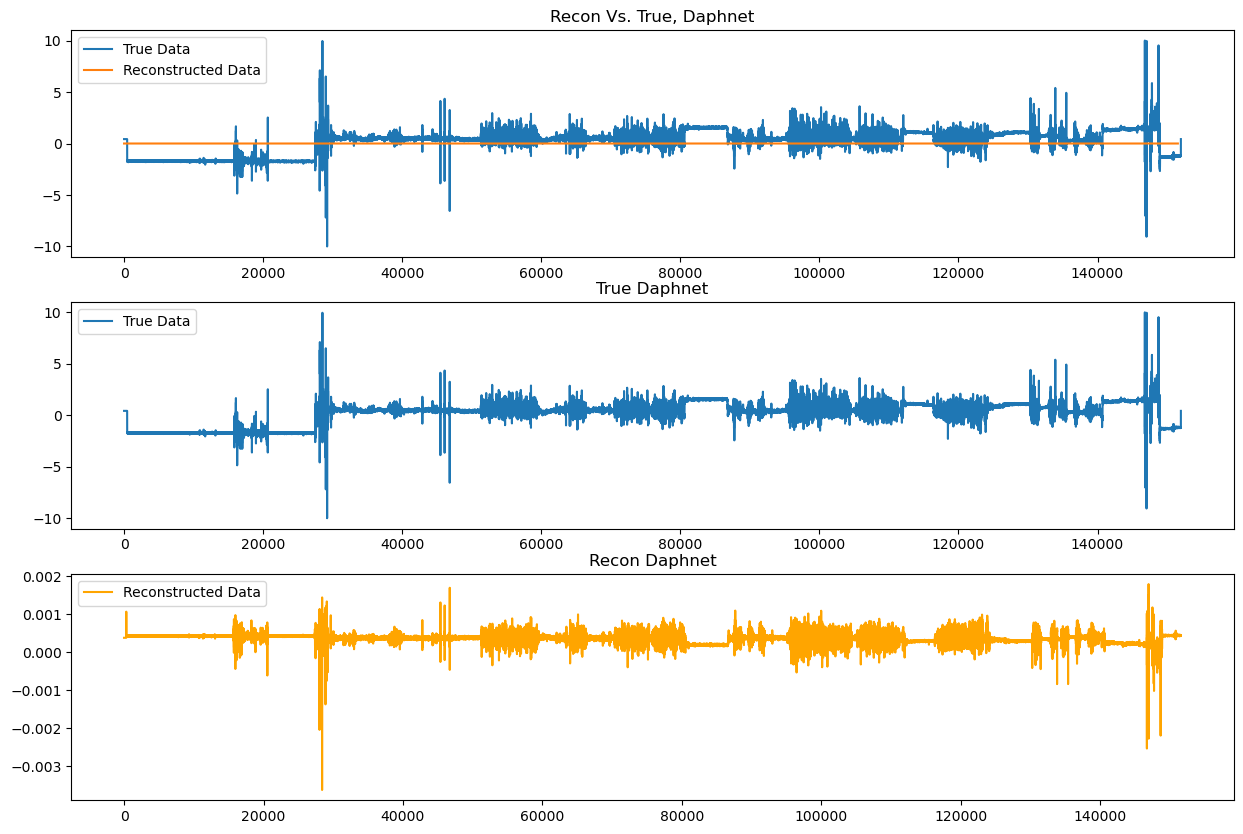

S01R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


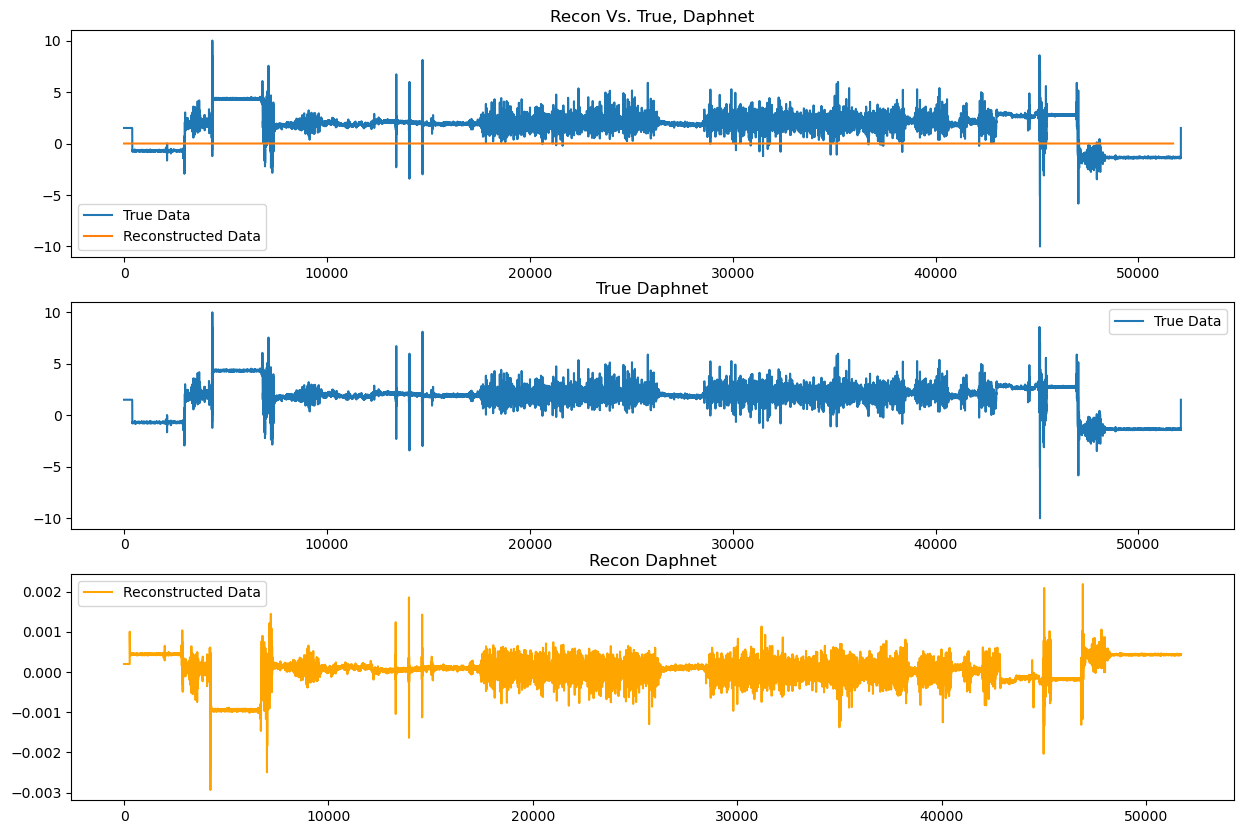

S02R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


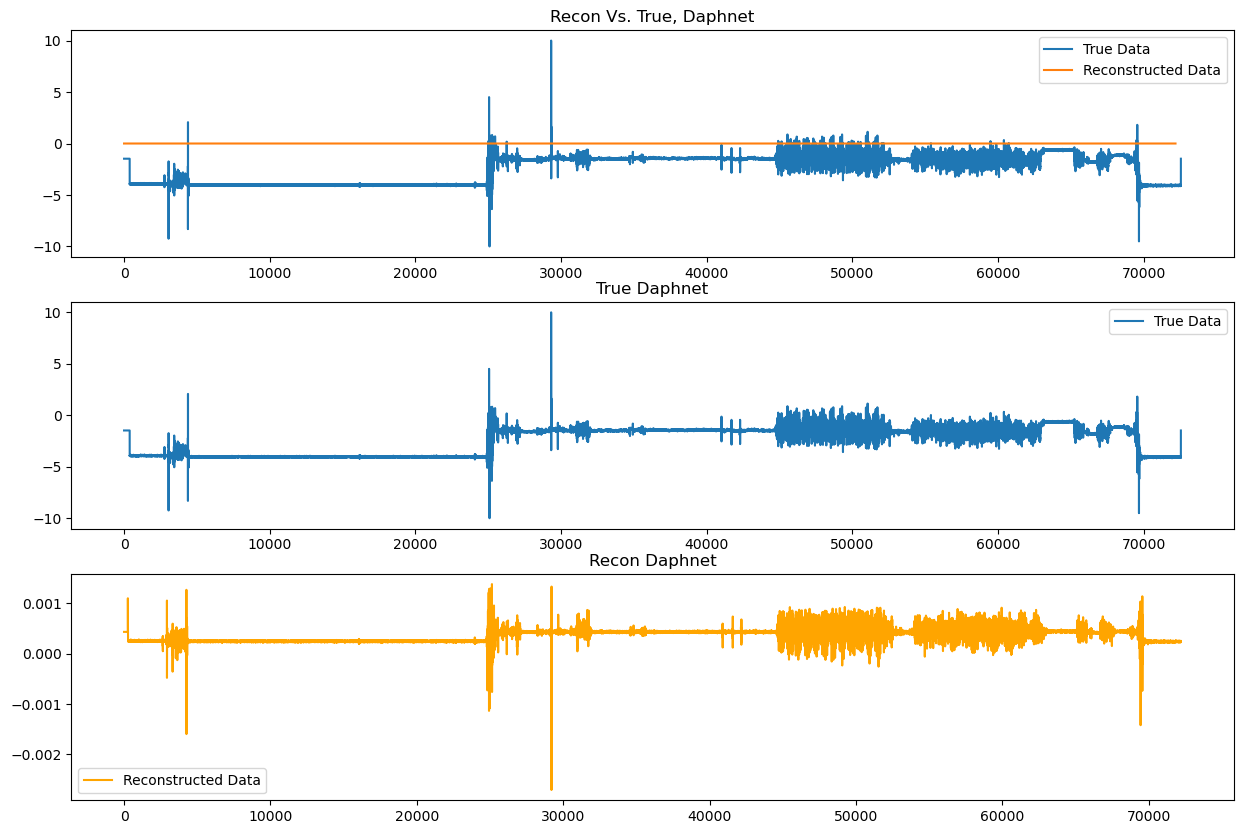

S02R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


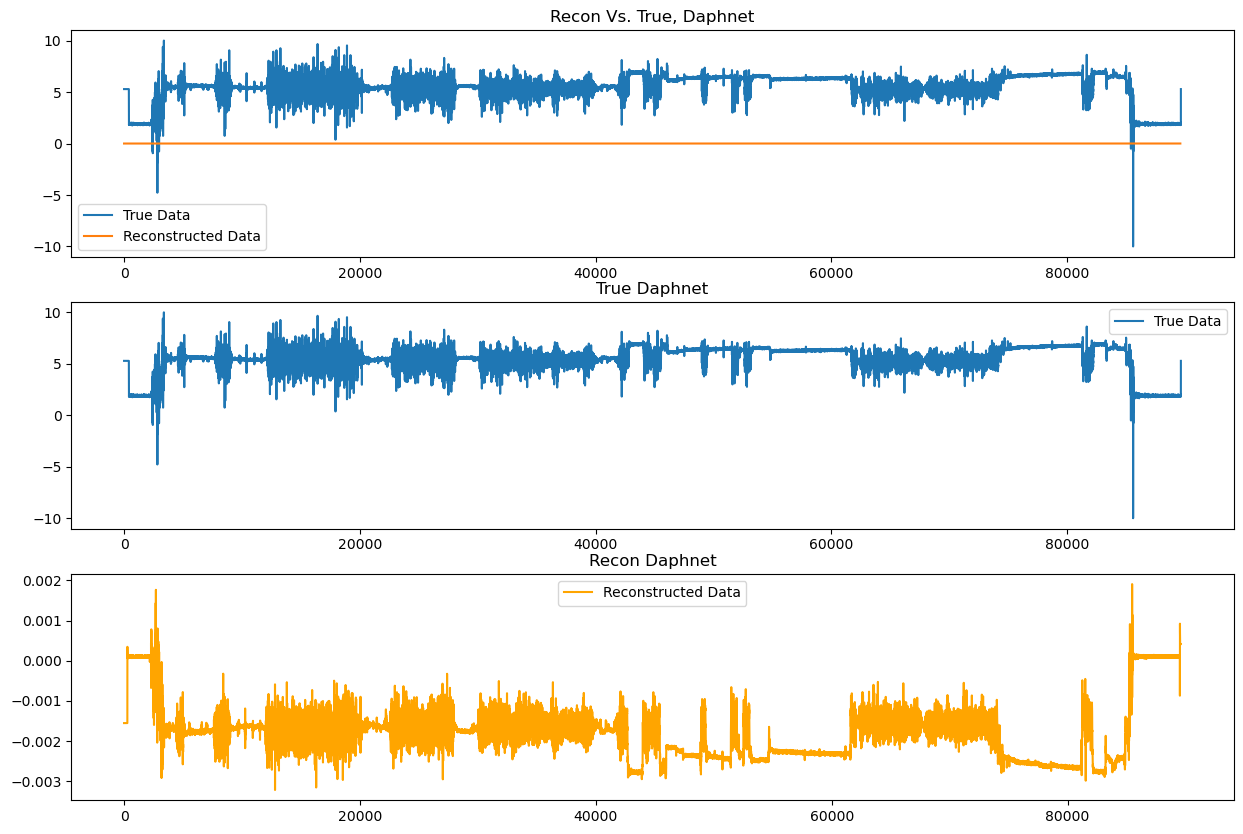

S03R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


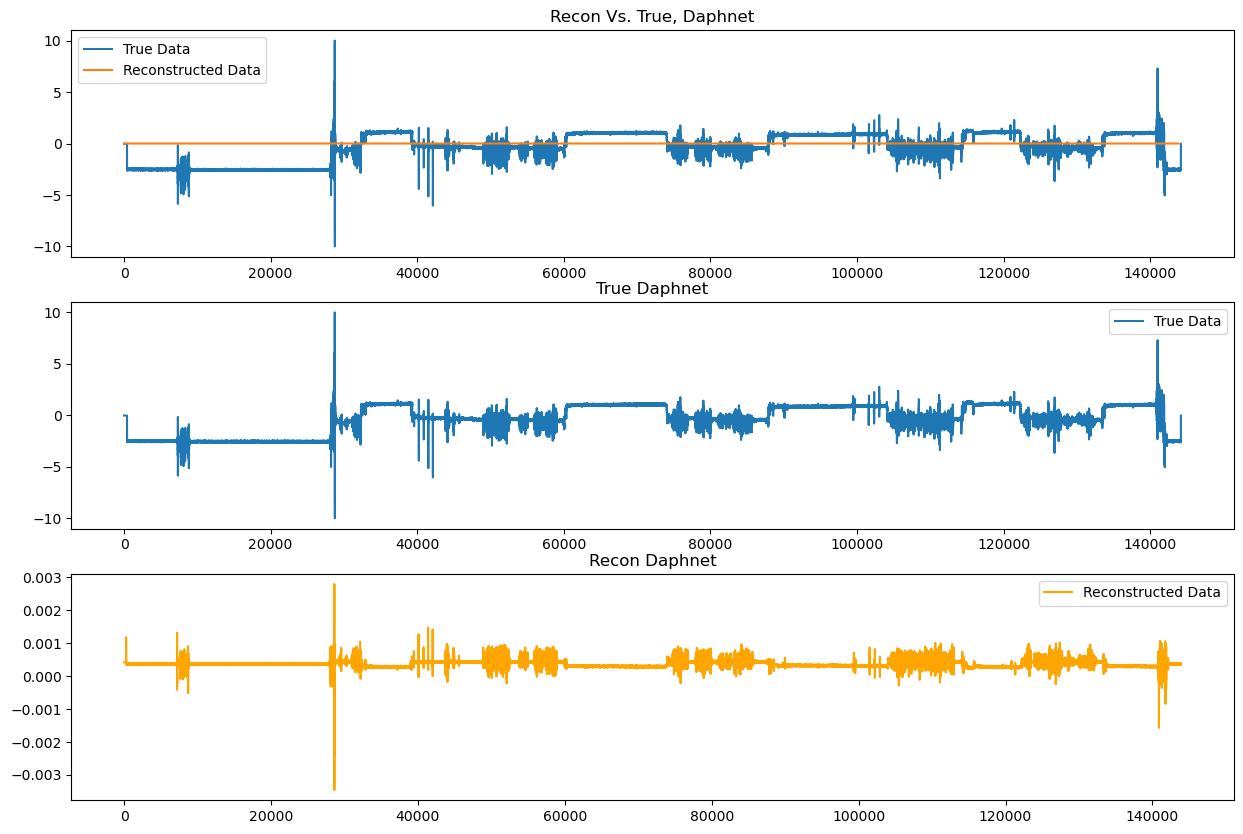

S03R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


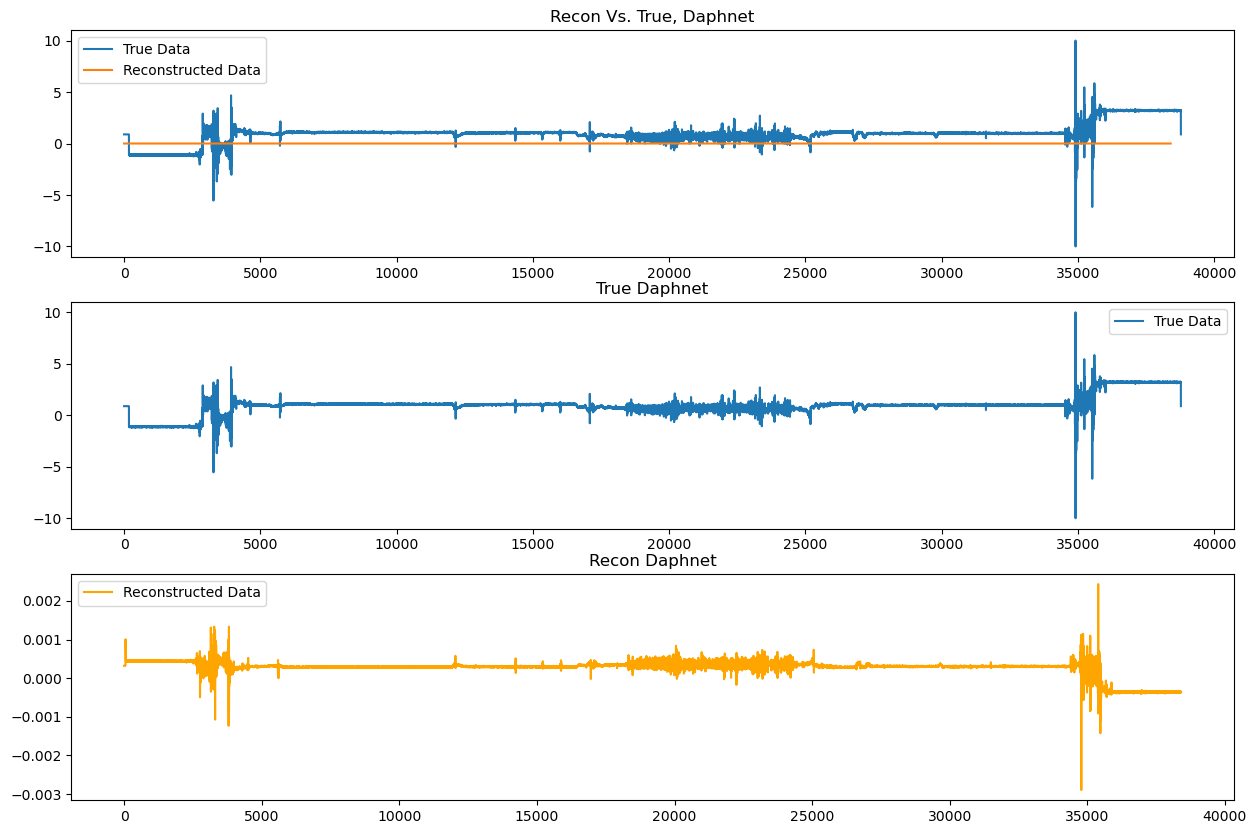

S03R03.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


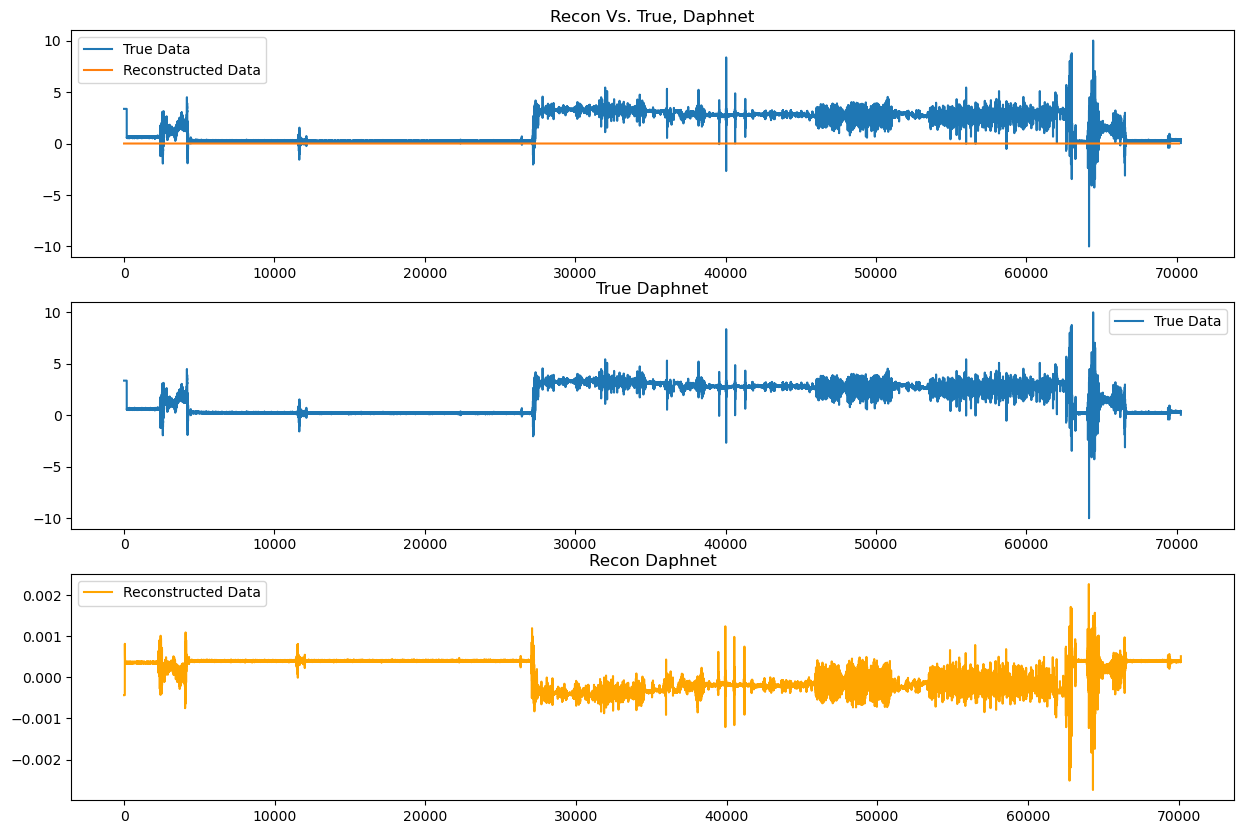

S04R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


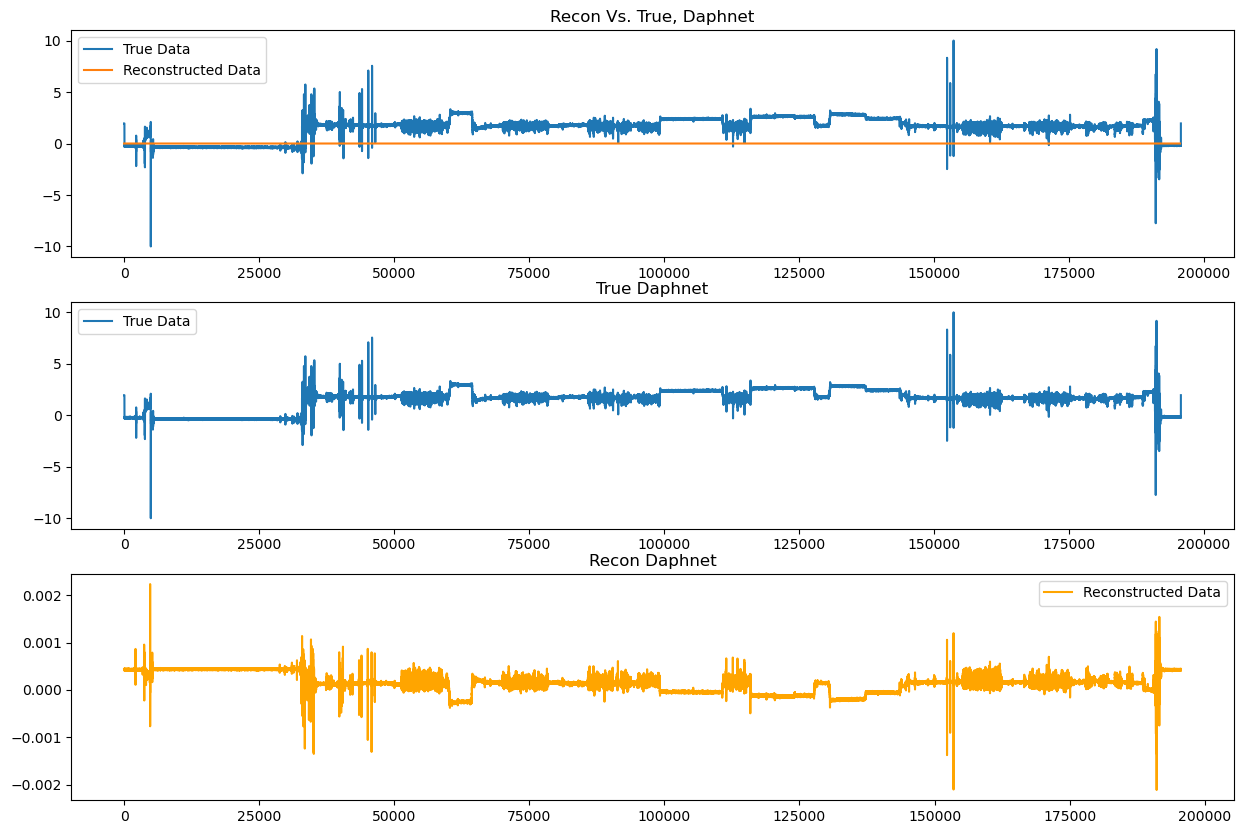

S05R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


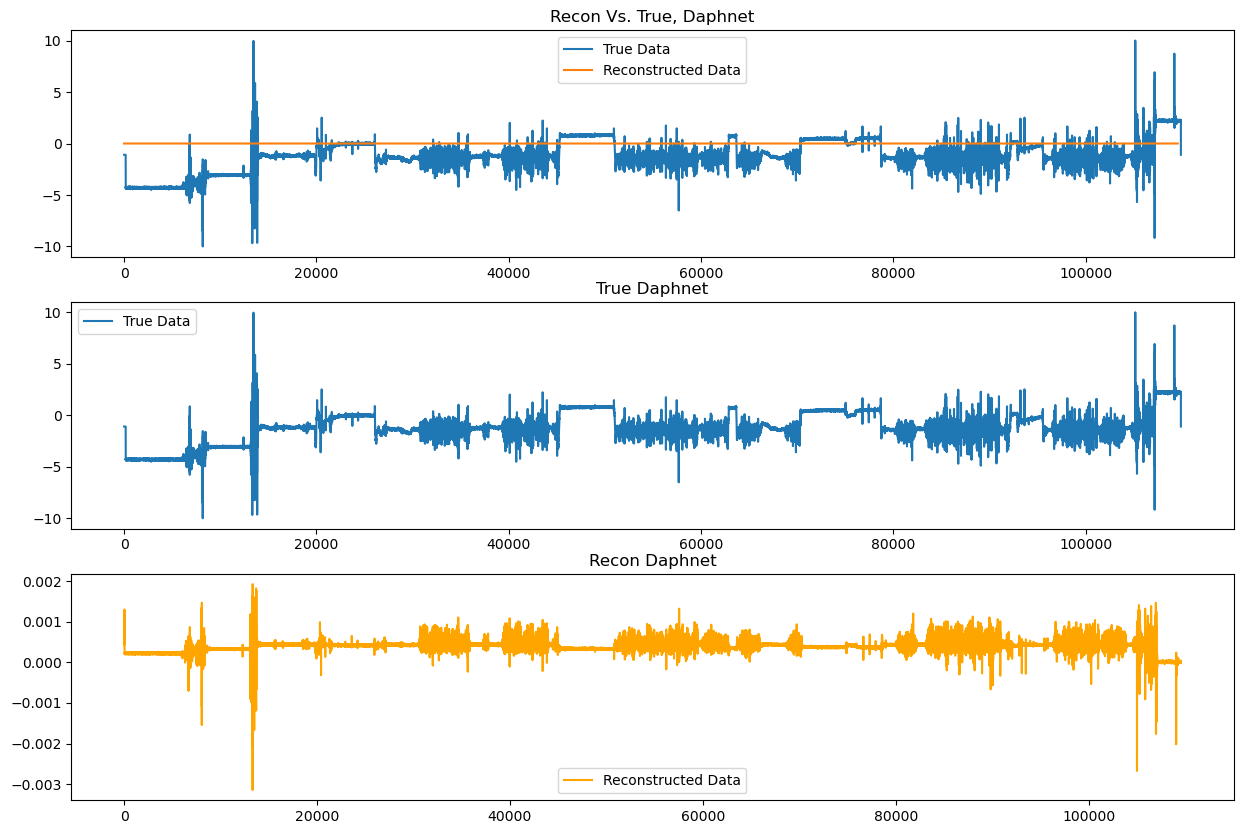

S05R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


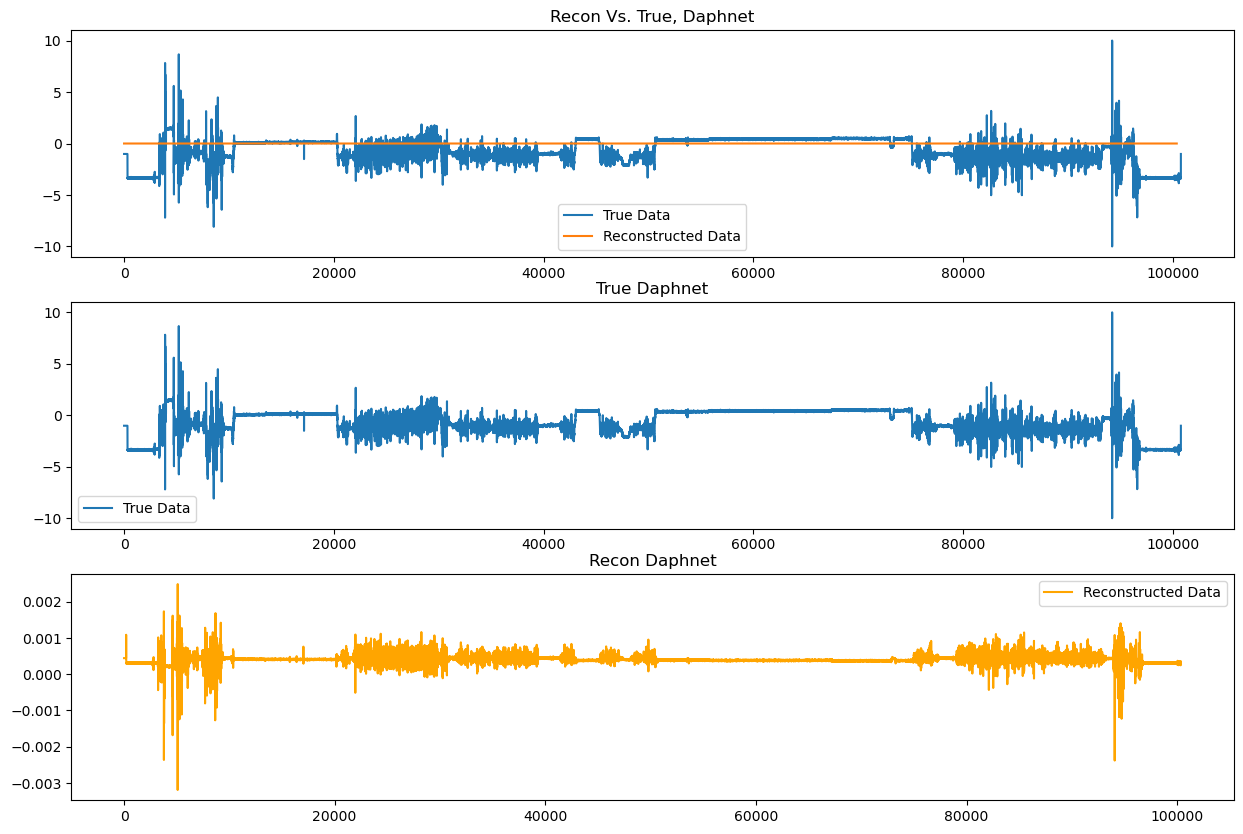

S06R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


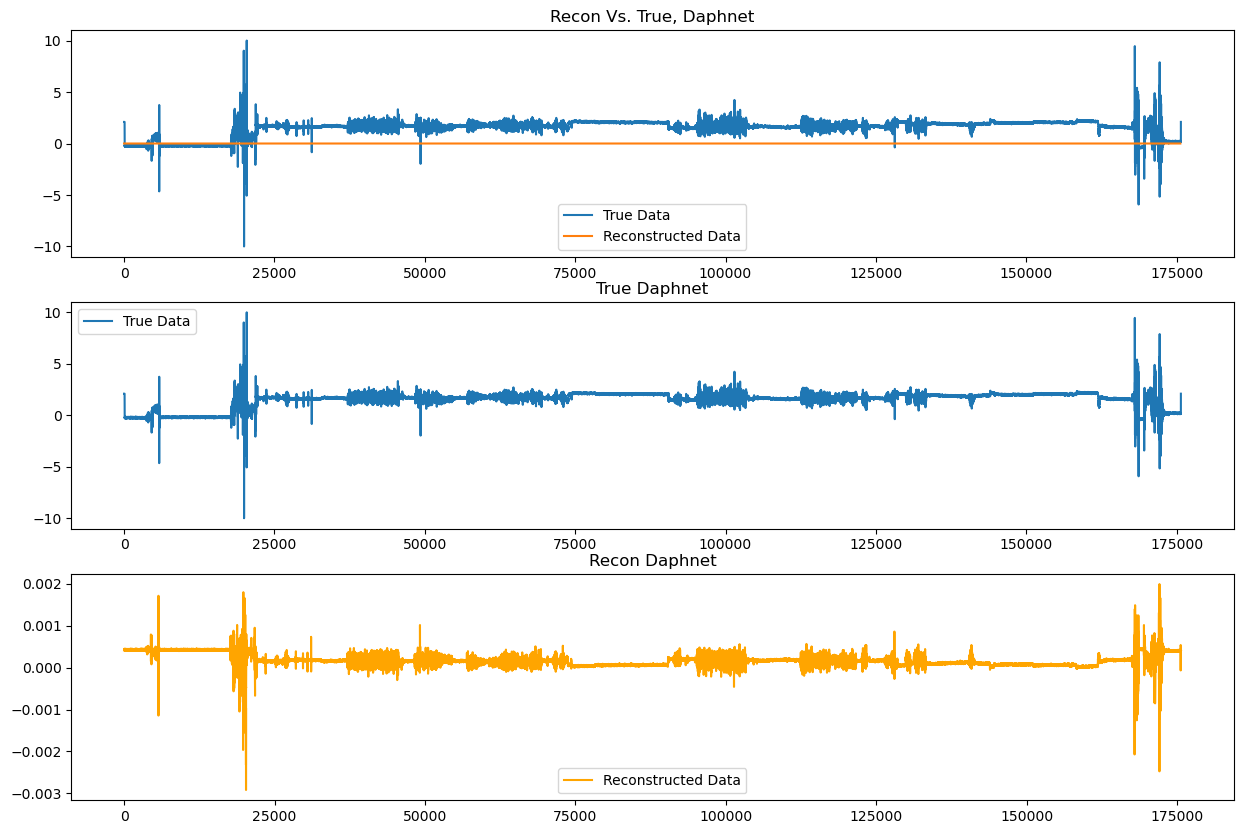

S06R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


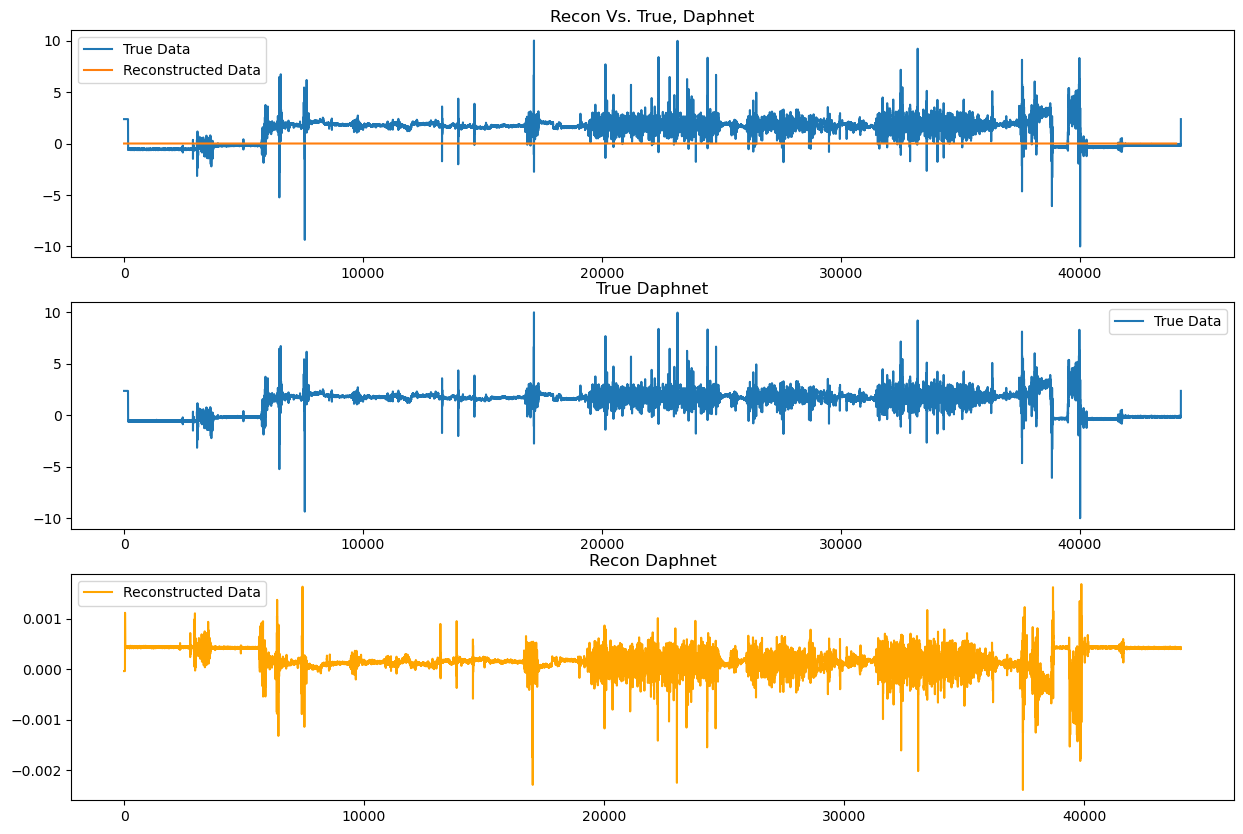

S07R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


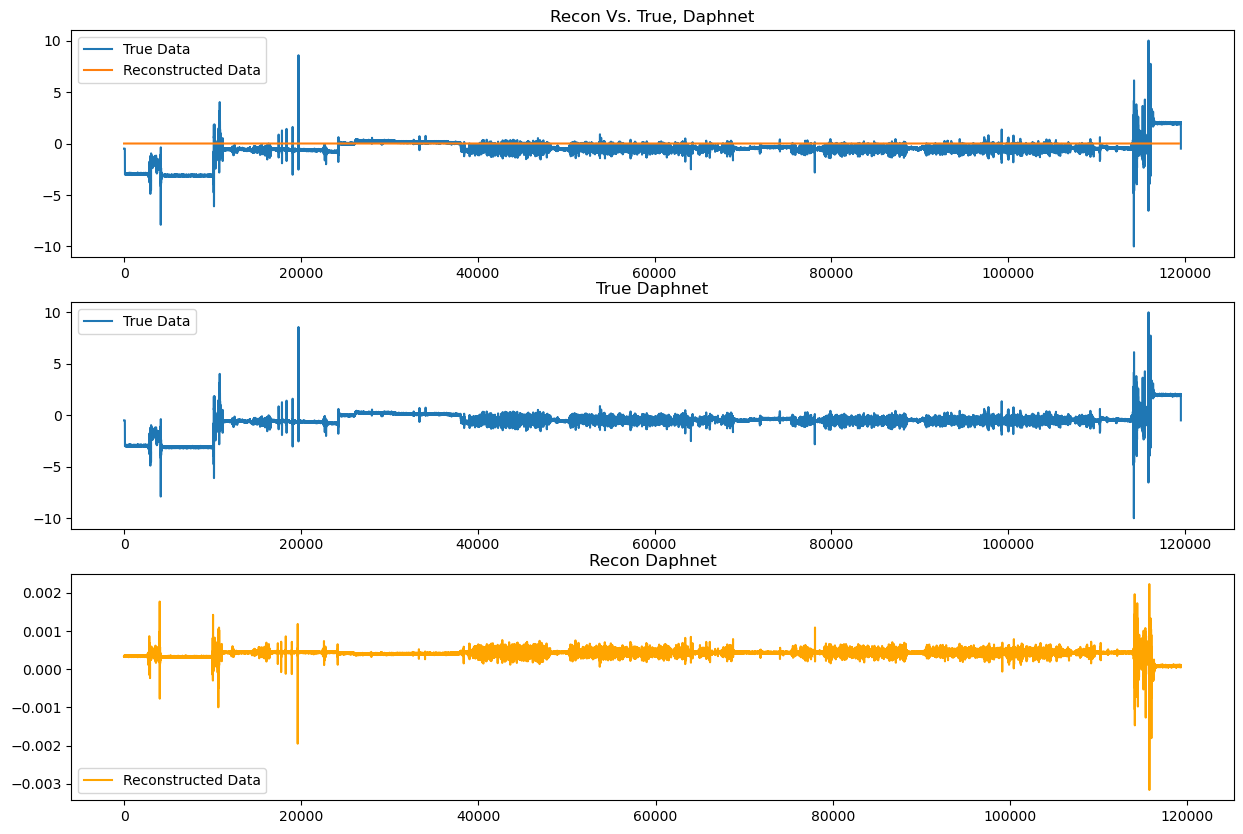

S07R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


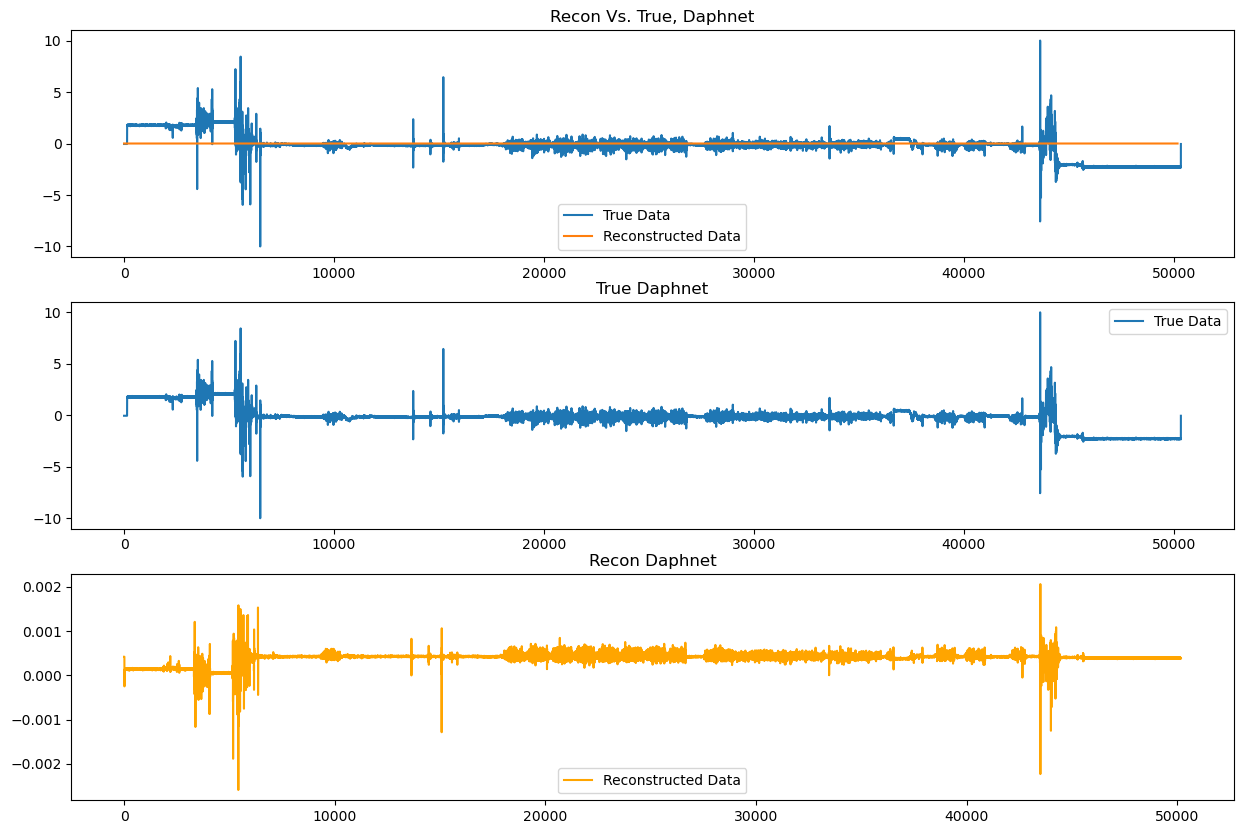

S08R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


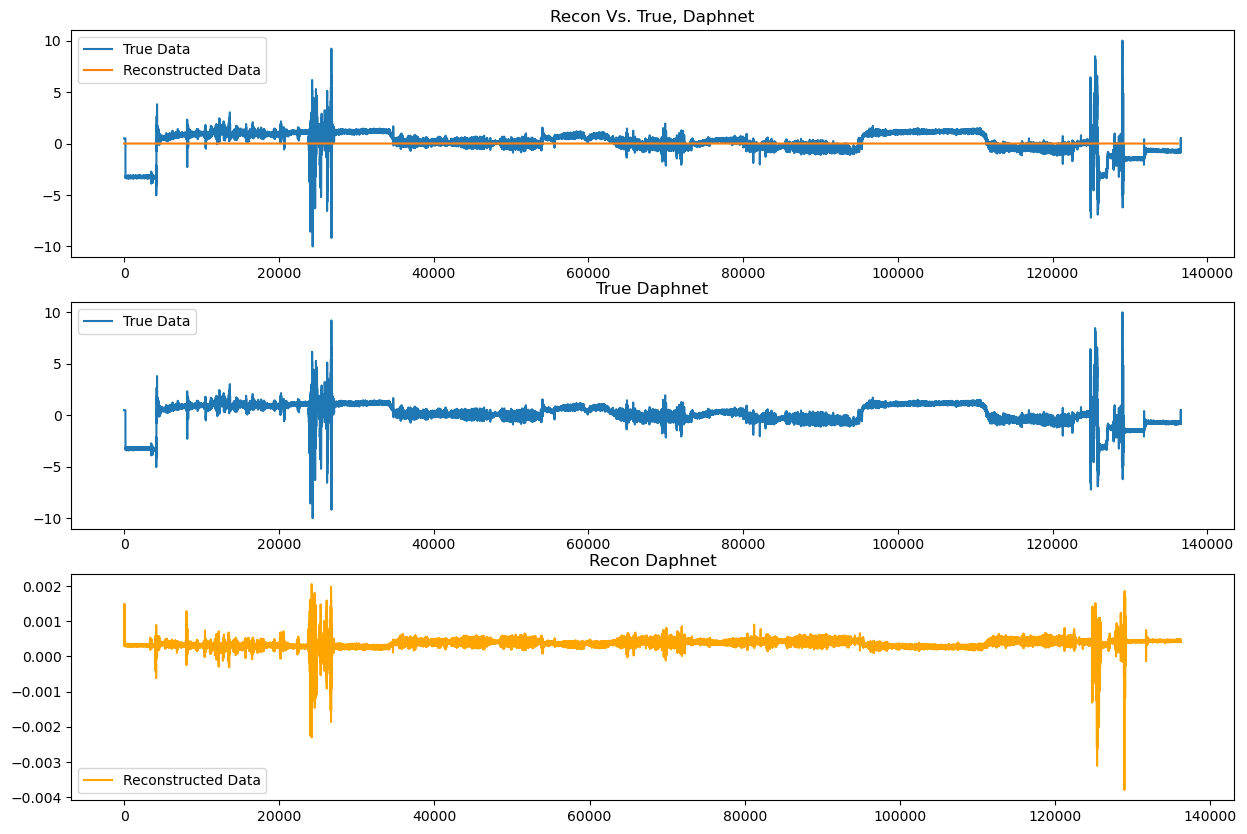

S09R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


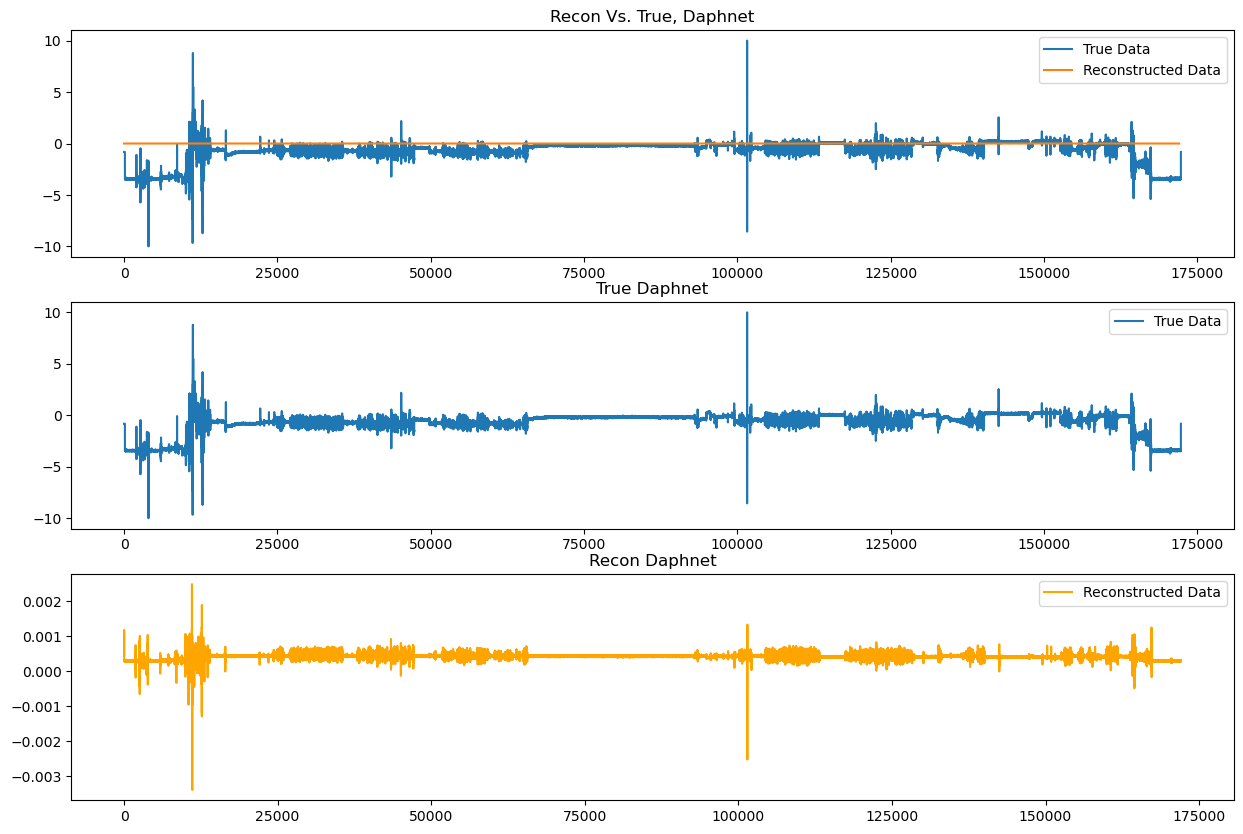

S10R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


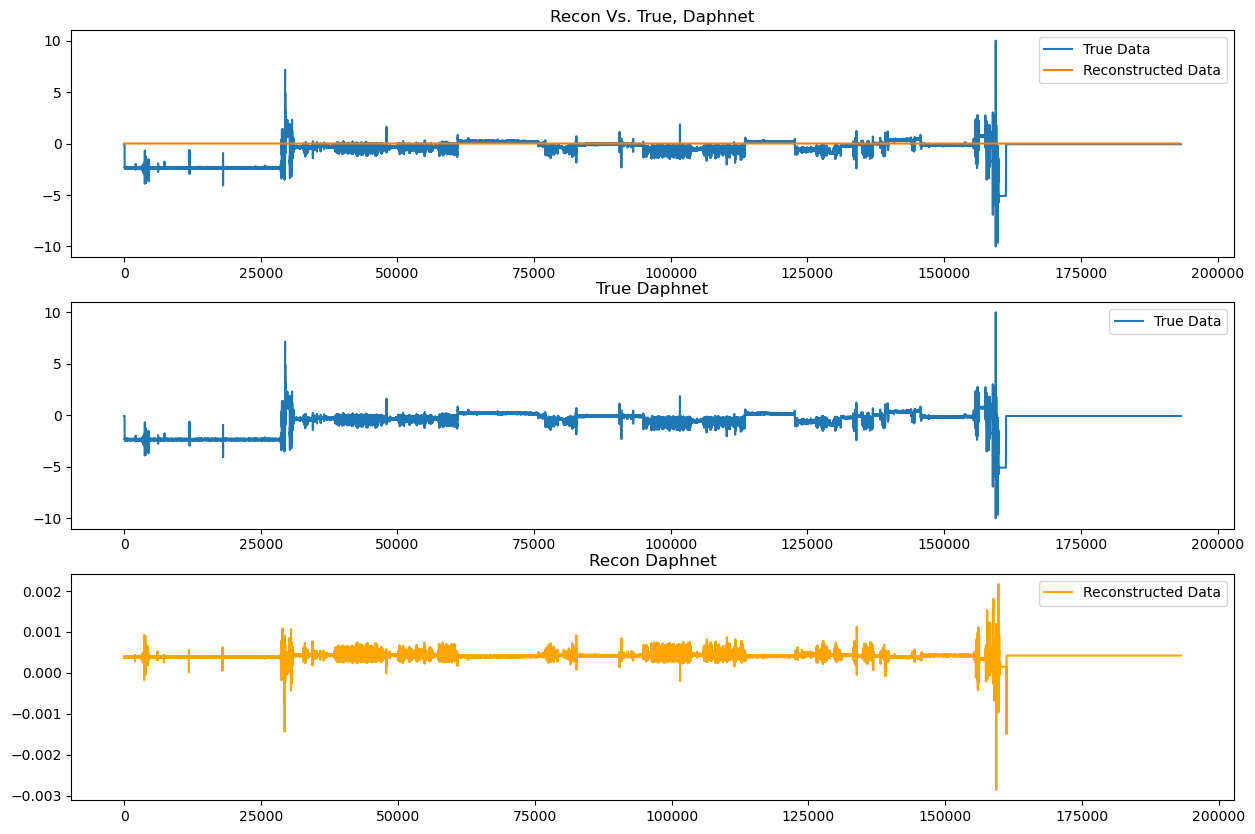

In [ ]:
plot_predictions_daphnet(model)

In [ ]:
# cwd = os.getcwd() + "/MHEALTHDATASET_CSV"
if(platform.system() == 'Windows'):
    cwd = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV'
else:
    cwd = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(cwd)

os.chdir(cwd)

#split data into sections by label

df = pd.DataFrame()
dataframes = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}/{file}"
        temp = pd.read_csv(file_path)
        dataframes.append(temp)
        print('file:', file, '| size = ', len(temp))
        
df = pd.concat(dataframes)

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTHDATASET_CSV
file: mHealth_subject1.csv | size =  161280
file: mHealth_subject10.csv | size =  98304
file: mHealth_subject2.csv | size =  130561
file: mHealth_subject3.csv | size =  122112
file: mHealth_subject4.csv | size =  116736
file: mHealth_subject5.csv | size =  119808
file: mHealth_subject6.csv | size =  98304
file: mHealth_subject7.csv | size =  104448
file: mHealth_subject8.csv | size =  129024
file: mHealth_subject9.csv | size =  135168


In [ ]:
#extracts x,y,z chest accel data into different label groups
def partition_data(label, dataframe):
    x_data = []
    y_data = []
    z_data = []
    activity = []
    
    for i in range(len(dataframe)):
        if(df['label'].iloc[i] == label):
            x_data.append(df['chest acceleration X-axis'].iloc[i])
            y_data.append(df['chest acceleration Y-axis'].iloc[i])
            z_data.append(df['chest acceleration Z-axis'].iloc[i])
            activity.append(df['label'].iloc[i])
            
    
    partitioned_df = pd.DataFrame(
                                  {
        'x-axis': x_data,
        'y-axis': y_data,
        'z-axis': z_data,
        'label': activity
                                  })
    
    return partitioned_df

In [ ]:
class classifier_dataset(torch.utils.data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe['x-axis']
        # print(self.dataset)
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+256].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        label = torch.tensor(self.labels.iloc[index])

        return sequence, label

#pad sequences that aren't 128 length with 0's
def classifier_collate_fn(data):
    labels = []
    for d in data:
        labels.append(torch.tensor(d[1]))
    
    labels = torch.tensor(labels)
    inputs = [torch.tensor(d[0]) for d in data]
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, labels

In [ ]:
X_train, X_test, y_train, y_test = [], [], [], []    
       
X = []
y = []

classifier_batch_size = 32

if(platform.system() == 'Windows'):
    partitioned_path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTH_PARTITIONED_CSV'
else:
    partitioned_path = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(partitioned_path)

os.chdir(partitioned_path)

for file in os.listdir():
    if file.endswith(".csv"):
        
        file_path = partitioned_path +'\\'+file
        
        print("Current file: ", file_path)
        
        temp = pd.read_csv(file_path)
        
        temp = temp.sample(n=1000, random_state=42)

        x_data = temp
        y_data = temp['label'].to_numpy()
        
        split_idx = int(len(x_data) * 0.8)

        class_train = classifier_dataset(
            dataframe=x_data[:split_idx]
        )

        class_test = classifier_dataset(
            dataframe=x_data[split_idx:]
        )

        class_train_loader = torch.utils.data.DataLoader(
            class_train, 
            batch_size=1, 
            shuffle=True, 
            drop_last=True,
            collate_fn=classifier_collate_fn
            )

        class_test_loader = torch.utils.data.DataLoader(
            class_test, 
            batch_size=1, 
            shuffle=True, 
            drop_last=True,
            collate_fn=classifier_collate_fn
            )

        expected_shape = (1, 256, 1)
        for batch_idx, (inputs, targets) in enumerate(class_train_loader):

            if(inputs.shape != expected_shape):
                continue
            
            inputs = inputs.cuda()
            inputs = inputs.squeeze(dim=0)
            inputs = inputs.squeeze(dim=1)

            
            X.append(inputs)
            y.append(targets.cpu().detach())
            
        
        for batch_idx, (inputs, targets) in enumerate(class_test_loader):
            if(inputs.shape != expected_shape):
                continue
            
            inputs = inputs.cuda()
            inputs = inputs.squeeze(dim=0)
            inputs = inputs.squeeze(dim=1)
            
            X.append(inputs)
            y.append(targets.cpu().detach())
            

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV
Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_arms.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_cycle.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_jog.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_jump.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_knee_bend.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_lying.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_null.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_run.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_sit.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_stairs.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_stand.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_waist_bend.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_walk.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_1744\4139630440.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


In [ ]:
class Classifier(nn.Module):

  def __init__(self, input_dim=256, num_classes=13, num_units=64, dropout=0.5, hidden=True):
    super(Classifier, self).__init__()
    
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_classes),
    )
    
  def forward(self, x):
    return self.linear_layer_stack(x)

class_train_loss = []
class_test_loss = []
class_accuracy = []

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ClassifierDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data (numpy.ndarray or list): The input data of shape (num_samples, input_size).
            labels (numpy.ndarray or list): The labels corresponding to the data, of shape (num_samples).
        """
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        temp_x = self.data[idx]

        return temp_x, self.labels[idx]

# Create the dataset
classifier_data = ClassifierDataset(X, y)

In [ ]:
import torch.nn.functional as F

def collate_fn_2(batch):
    """
    Custom collate function that pads tensors to the maximum size in the batch.
    
    Args:
        batch: A list of tensors of varying sizes, each with shape (1, *, 1).
    
    Returns:
        A single tensor of shape (batch_size, 1, max_height, 1).
    """
    # Determine the maximum height (second dimension) in the batch
    max_height = 256
    
    # Pad each tensor to have the same height
    padded_batch = []
    # print(batch)
    for tensor in batch:
        # print(type(tensor))
        tensor = batch[0]
        print(type(tensor))
        height = tensor.shape()
        
        height = height[0, :, 0]
        if height < max_height:
            # Calculate padding
            padding = max_height - height
            # Pad tensor: pad (height, width) dimensions, not the batch dimension
            padded_tensor = F.pad(tensor, pad=(0, 0, 0, padding), mode='constant', value=0)
        else:
            padded_tensor = tensor
        padded_batch.append(padded_tensor)
        
        
    labels = []
    for d in batch:
        labels.append(torch.tensor(d[1]))
    
    # Stack the tensors to form a batch
    return torch.stack(padded_batch), labels

def collate_fn_2(data):
    labels = []
    for d in data:
        labels.append(torch.tensor(d[1]))
    
    inputs = [torch.tensor(d[0]) for d in data]
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, labels

In [ ]:
# classifier_batch_size = 4

# classifier_split_idx = int(len(classifier_data) * 0.8)
# print("split: ", classifier_split_idx)

# classifier_train_loader = DataLoader(
#                             classifier_data[:classifier_split_idx], 
#                             batch_size=classifier_batch_size, 
#                             collate_fn=collate_fn_2,
#                             shuffle=True,
#                             drop_last=False
#                         )

# classifier_val_loader = DataLoader(
#                             classifier_data[classifier_split_idx:], 
#                             batch_size=classifier_batch_size, 
#                             collate_fn=collate_fn_2,
#                             shuffle=True
#                         )

In [ ]:
# # Example of iterating through the DataLoader
# train_features, train_labels = next(iter(classifier_train_loader))
# print(f"Feature batch shape: {train_features.size()}")

# for batch in classifier_train_loader:
#     print("data shape: ", batch[0].shape)
#     print(type(batch[0]))
#     break
        
# print(len(classifier_train_loader))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

def train_classifier(classifier, criterion, optimizer, num_epochs=10, device='cpu'):
    classifier.to(device)  # Move the model to the specified device (GPU or CPU)
    
    for epoch in range(num_epochs):
        classifier.train()  # Set the model to training mode
        running_loss = 0.0
        
        for inputs, labels in zip(X_train, y_train):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            inputs = inputs.unsqueeze(dim=0)
            inputs = inputs.unsqueeze(dim=2)
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            inputs, _ = model.encode(inputs)
            
            # Forward pass
            outputs = classifier(inputs.to(device))
            outputs = outputs[0, :, :]

            loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss
            running_loss += loss.item() * inputs.size(0)
        
        # Calculate average loss over an epoch
        epoch_loss = running_loss / len(X_train)
        class_train_loss.append(epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')
        
        classifier.eval()  # Set the model to evaluation mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in zip(X_test, y_test):
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
                
                inputs = inputs.unsqueeze(dim=0)
                inputs = inputs.unsqueeze(dim=2)

                inputs, _ = model.encode(inputs)
            
                # Forward pass
                outputs = classifier(inputs.to(device))
                outputs = outputs[0, :, :]
                
                loss = criterion(outputs, labels.type(torch.LongTensor).to(device))  # Compute the loss
                running_loss += loss.item() * inputs.size(0)  # Accumulate the loss
                _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()  # Count correct predictions
                
        avg_loss = running_loss / len(X_test)  # Average loss per batch
        class_test_loss.append(avg_loss)
        accuracy = correct / total  # Accuracy calculation
        print(f'Validation Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')
        
    print('Training complete')


In [ ]:
LOAD_CLASSIFIER = False

classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

if(LOAD_CLASSIFIER):
    classifier.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\128_latent_classifier'))
else:
    # Assuming train_loader is defined
    train_classifier(classifier, criterion, optimizer, num_epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu')

    torch.save(classifier.state_dict(), 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\128_latent_classifier')

ValueError: not enough values to unpack (expected 2, got 1)

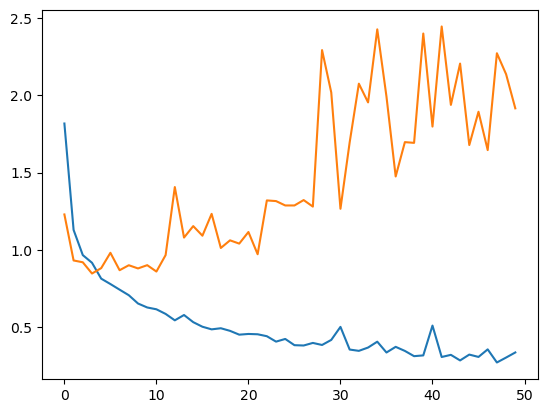

In [ ]:
plt.plot(class_train_loss)
plt.plot(class_test_loss)

In [ ]:
# import torch
# import torch.optim as optim
# import torch.nn as nn

# def train_classifier(classifier, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
#     classifier.to(device)  # Move the model to the specified device (GPU or CPU)
    
#     for epoch in range(num_epochs):
#         classifier.train()  # Set the model to training mode
#         running_loss = 0.0
        
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            
#             # Zero the parameter gradients
#             optimizer.zero_grad()
            
#             inputs, _ = model.encode(inputs)
            
#             # Forward pass
#             outputs = classifier(inputs.to(device))
#             outputs = outputs[0, :, :]
            
#             loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
            
#             # Backward pass and optimize
#             loss.backward()
#             optimizer.step()
            
#             # Accumulate the loss
#             running_loss += loss.item() * inputs.size(0)
        
#         # Calculate average loss over an epoch
#         epoch_loss = running_loss / len(train_loader.dataset)
        
#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')
        
#         classifier.eval()  # Set the model to evaluation mode
#         running_loss = 0.0
#         correct = 0
#         total = 0
        
#         with torch.no_grad():  # Disable gradient calculation for evaluation
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
                
#                 print(inputs.shape)
#                 inputs, _ = model.encode(inputs)
            
#                 # Forward pass
#                 outputs = classifier(inputs.to(device))
#                 outputs = outputs[0, :, :]
                
#                 loss = criterion(outputs, labels)  # Compute the loss
#                 running_loss += loss.item() * inputs.size(0)  # Accumulate the loss
#                 _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()  # Count correct predictions
                
#         avg_loss = running_loss / len(val_loader.dataset)  # Average loss per batch
#         accuracy = correct / total  # Accuracy calculation
#         print(f'Validation Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')
        
#         print('Training complete')

# # Example usage:
# classifier = Classifier().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# # Assuming train_loader is defined
# train_classifier(classifier, classifier_train_loader, classifier_val_loader, criterion, optimizer, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu')


NameError: name 'classifier_train_loader' is not defined

In [ ]:
# a = pd.read_csv(r'C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_arms.csv')
# a

,x-axis,y-axis,z-axis,label
0,-9.3187,0.78520,2.0601,7.0
1,-10.3470,0.65888,1.5435,7.0
2,-10.3320,0.45855,1.3886,7.0
3,-9.9735,0.69687,2.1575,7.0
4,-9.7907,0.64792,2.1846,7.0
...,...,...,...,...
29436,-9.2102,-2.11760,1.5357,7.0
29437,-9.5888,-1.87200,1.8526,7.0
29438,-9.8425,-2.31800,1.7598,7.0
29439,-9.3843,-2.50150,1.3749,7.0


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier

# # Split the dataset into train and test sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Initialize the RandomForestClassifier
# rf_clf = RandomForestClassifier(n_estimators=500, random_state=42)
# gb_clf = GradientBoostingClassifier(n_estimators=500, random_state=42)
# svc_clf = SVC(probability=True, random_state=42)
# dt_clf = DecisionTreeClassifier(random_state=42)
# ada_clf = AdaBoostClassifier(n_estimators=500, random_state=42)

# print(type(X_train))
# # Training loop
# ensemble_clf = VotingClassifier(estimators=[
#     ('rf', rf_clf), 
#     ('gb', gb_clf), 
#     ('svc', svc_clf),
#     ('dt', dt_clf),
#     ('ada', ada_clf)], 
#     voting='soft'  # 'soft' uses predicted probabilities for majority rule
# )

# # feature_names = [f"feature {i}" for i in range(X.shape[1])]
# rf_clf.fit(X_train, y_train)

# # Make predictions
# y_pred = rf_clf.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)


<class 'list'>


C:\Users\Admin\AppData\Local\Temp\ipykernel_40936\1825797081.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier

# rf_clf = RandomForestClassifier(n_estimators=500, random_state=42)

# rf_clf.fit(X_train, y_train)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


Text(0, 0.5, 'Mean decrease in impurity')

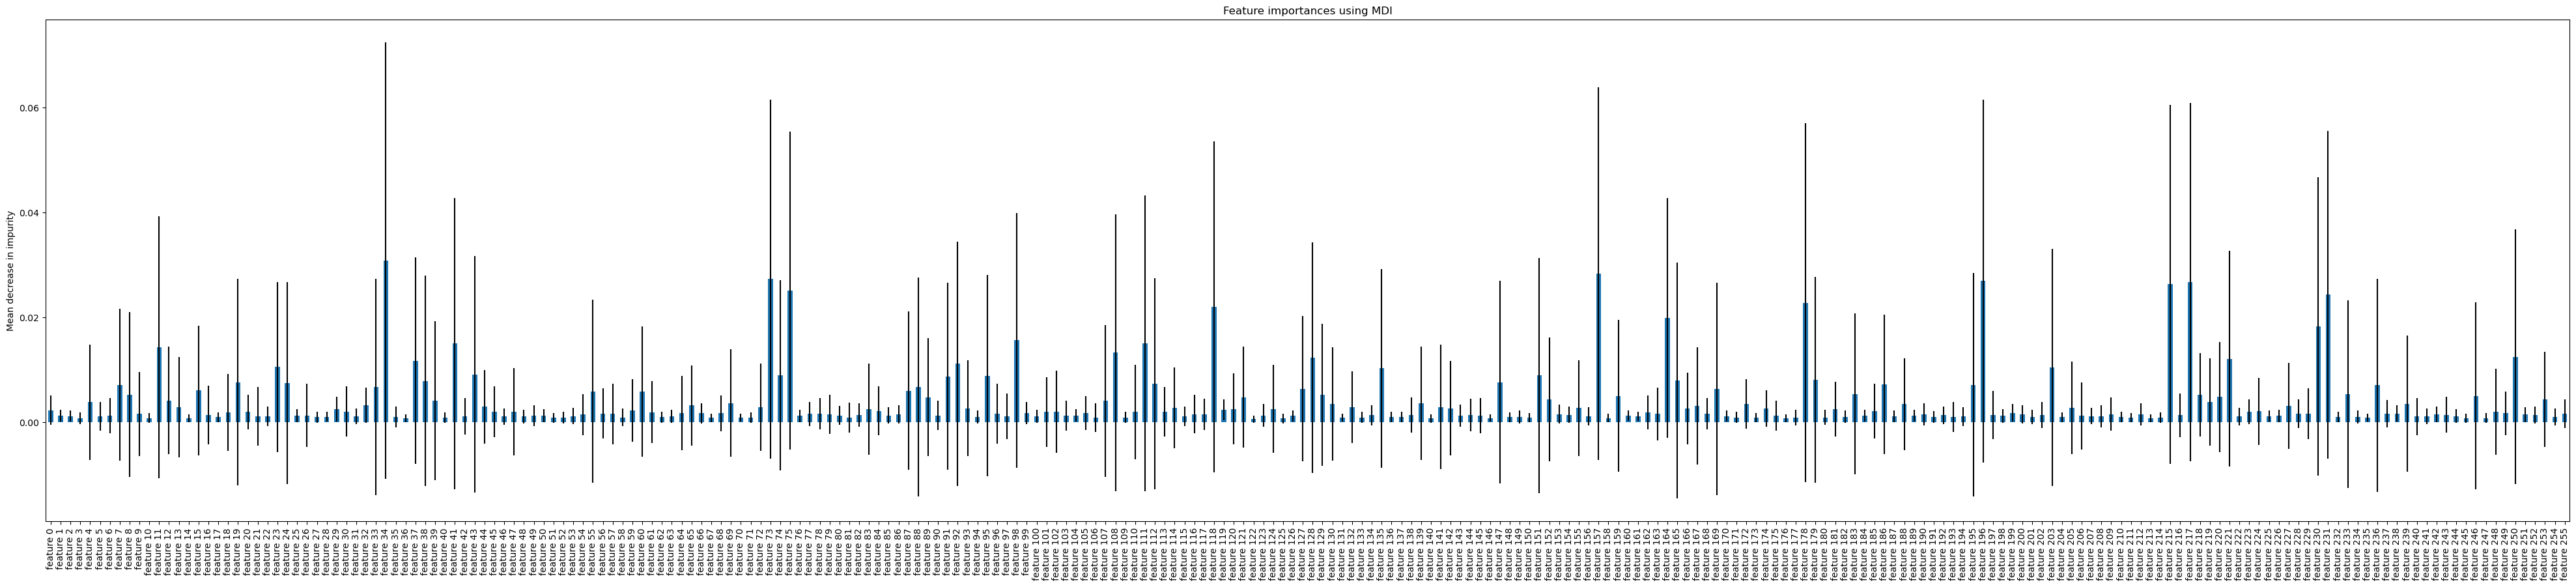

In [ ]:
# from matplotlib.pyplot import figure

# importances = rf_clf.feature_importances_

# feature_names = [f"feature {i}" for i in range(256)]
# forest_importances = pd.Series(importances, index=feature_names)
# std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

# fig, ax = plt.subplots(figsize=(50, 10))

# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# # fig.tight_layout()

In [ ]:
# import math
# nan_indices = [i for i, value in enumerate(y_test) if isinstance(value, float) and math.isnan(value)]
# unknown_indices = [i for i, value in enumerate(y_test) if value == 'unknown']

# print(nan_indices)
# print(unknown_indices)

[]
[]


C:\Users\Admin\AppData\Local\Temp\ipykernel_40936\1296127855.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  unknown_indices = [i for i, value in enumerate(y_test) if value == 'unknown']


In [ ]:
# # Evaluate the model
# print(type(y_test))
# print(type(y_pred))
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


<class 'list'>
<class 'numpy.ndarray'>
Accuracy: 0.8040

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        73
         1.0       1.00      1.00      1.00        73
         2.0       0.83      1.00      0.91        73
         3.0       1.00      1.00      1.00        73
         4.0       0.77      0.88      0.82        73
         5.0       0.86      0.74      0.79        73
         6.0       0.64      0.89      0.74        73
         7.0       1.00      0.79      0.89        73
         8.0       0.96      1.00      0.98        73
         9.0       1.00      1.00      1.00        73
        10.0       0.52      0.77      0.62        73
        11.0       0.13      0.08      0.10        73
        12.0       0.71      0.41      0.52        73

    accuracy                           0.80       949
   macro avg       0.80      0.80      0.79       949
weighted avg       0.80      0.80      0.79       949


In [ ]:
# learning_rate = 0.001
# num_epochs = 10
# i = 0

# criterion = nn.CrossEntropyLoss()  # Since it's a classification task
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
    
#     model.train()
#     running_train_loss = 0.0
    
#     for idx in range(len(X_train)):
        
#         optimizer.zero_grad()
        
#         temp_x_train = X_train[idx]        
#         temp_x_train = torch.tensor(temp_x_train)
#         temp_x_train = temp_x_train.unsqueeze(dim=0)
#         temp_x_train = (temp_x_train).unsqueeze(dim=2)

#         encoded, _ = model.encode(temp_x_train.to(device))
#         encoded = encoded[0, :, :]
                
#         # Forward pass
#         outputs = classifier(encoded.to(device)).to(device)
        
#         # assert outputs.shape[0] == 13, f"Output shape mismatch: {outputs.shape}"
#         # assert targets.shape[0] == 4, f"Target shape mismatch: {targets.shape}"
              
#         y_pred = torch.round(torch.sigmoid(outputs))
#         # print("output shape: ", outputs.shape, " | ", outputs)
#         # print("target: ", y_train[idx])
#         loss = criterion(outputs, torch.tensor(y_train[idx]).type(torch.LongTensor).to(device))
        
#         running_train_loss += loss.item() * inputs.size(0)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0
#     running_test_loss = 0.0
    
#     epoch_train_loss = running_train_loss / len(class_train_loader)
#     class_train_loss.append(float(epoch_train_loss))

#     with torch.no_grad():
#         for idx in range(len(X_test)):
            
#             temp_x_test = X_test[idx]
#             temp_x_test = torch.tensor(temp_x_test)
#             temp_x_test = (temp_x_test).unsqueeze(dim=0)
#             temp_x_test = (temp_x_test).unsqueeze(dim=2)
            
#             encoded, _ = model.encode(temp_x_test.to(device))
#             encoded = encoded[0, :, :]
#             outputs = classifier(encoded).to(device)
            
#             loss = criterion(outputs, torch.tensor(y_test[idx]).type(torch.LongTensor).to(device))
#             running_test_loss += loss.item() * inputs.size(0)
            
#             _, predicted = torch.max(outputs, 1)
#             total += targets.size(0)
#             correct += (predicted.to(device) == targets.to(device)).sum().item()
    

#     epoch_test_loss = running_test_loss / len(class_test_loader)
#     class_test_loss.append(epoch_test_loss)
#     val_accuracy = correct / total

#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# print("Training complete.")
